In [2]:
!pip install statsmodels

     |████████████████████████████████| 10.5MB 1.7MB/s eta 0:00:01    |█                               | 317kB 1.7MB/s eta 0:00:06
     |████████████████████████████████| 235kB 17.3MB/s eta 0:00:01


In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d
from matplotlib import pyplot
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.ar_model import AR
from pylab import rcParams
from sklearn.feature_selection import RFE
from pandas import read_csv
from pathlib import Path

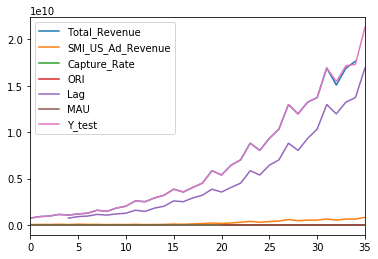

In [21]:
TEMPLATES_DIR = Path.cwd().joinpath('Resources')
companies = ['GOOGL', 'FB', 'TWTR', 'SNAP']
file = TEMPLATES_DIR.joinpath(companies[1] + ".csv")

df = pd.read_csv(file)
df.head()
df.plot()
pyplot.show()

In [63]:
df.columns
df = pd.get_dummies(df)
#dummy = pd.get_dummies(df['Quarter'])
#df= pd.concat([df,dummy],axis = 1)
print(df.head())
df.isnull().any()
print(df.columns)
df = df.fillna(method = 'ffill')
df = df.interpolate(method ='linear', limit_direction ='backward')
df = df.interpolate(method = 'linear',limit_direction = 'forward',limit = 1)

   Total_Revenue  SMI_US_Ad_Revenue  Capture_Rate     ORI          Lag  MAU  \
0   7.310000e+08           36658226          0.05  217.74  731000000.0  680   
1   8.950000e+08           51035923          0.06  217.74  731000000.0  739   
2   9.540000e+08           50442128          0.05  217.74  731000000.0  800   
3   1.131000e+09           66235153          0.06  217.74  731000000.0  845   
4   1.058000e+09           45784188          0.04  217.74  731000000.0  901   

       Y_test  Time_2011-Q1  Time_2011-Q2  Time_2011-Q3  ...  Y_test_YoY_39%  \
0   731000000             1             0             0  ...               0   
1   895000000             0             1             0  ...               0   
2   954000000             0             0             1  ...               0   
3  1131000000             0             0             0  ...               0   
4  1058000000             0             0             0  ...               0   

   Y_test_YoY_41%  Y_test_YoY_42%  Y_test_Yo

In [23]:
##model with MAU and Capture Rate
def ModelA(df):
    X = df[['SMI_US_Ad_Revenue','Lag','MAU','ORI','Capture_Rate','Quarter_Q1',
       'Quarter_Q2', 'Quarter_Q3', 'Quarter_Q4'] ]
    y = df['Total_Revenue'].values.reshape(-1,1)
    return X,y

In [24]:
##model with Capture Rate and without MAU

def ModelB(df):
    X = df[['SMI_US_Ad_Revenue','Lag','Capture_Rate','Quarter_Q1',
       'Quarter_Q2', 'Quarter_Q3', 'Quarter_Q4'] ]
    y = df['Total_Revenue'].values.reshape(-1,1)
    return X,y


In [25]:
##model without MAU and Capture Rate
def ModelC(df):
    X = df[['SMI_US_Ad_Revenue','Lag','Quarter_Q1',
        'Quarter_Q2', 'Quarter_Q3', 'Quarter_Q4'] ]
    y = df['Total_Revenue'].values.reshape(-1,1)  
    return X,y

In [26]:
X,y = ModelA(df)

In [66]:
from sklearn.model_selection import train_test_split

test_percentage = .66
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= test_percentage, shuffle = False, random_state=42)
#X_train,X_test,y_train,y_test = train_test_split(X,y,random_state = 42)

In [67]:
from sklearn.preprocessing import StandardScaler
def scaler(X_train,y_train,X_test):
    #X_scaler = StandardScaler().fit(X_train)
    #y_scaler = StandardScaler().fit(y_train)
    #X_test = X_test.values.reshape(1, -1)
    #y_train = y_train.reshape(-1,1)
    X_train_scaled = StandardScaler().fit(X_train).transform(X_train)
    X_test_scaled = StandardScaler().fit(X_train).transform(X_test)
    y_train_scaled = StandardScaler().fit(y_train).transform(y_train)
    return X_train_scaled,y_train_scaled,X_test_scaled
def scaler_y_test(y_test,y_train):
    y_test_scaled = StandardScaler().fit(y_train).transform(y_test)
    return y_test_scaled

X_train_scaled,y_train_scaled,X_test_scaled, = scaler(X_train,y_train,X_test)
y_test_scaled = scaler_y_test(y_test,y_train)

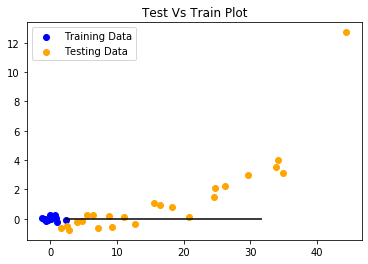

In [69]:
model = LinearRegression()
#predictions = model.predict(X_test_scaled)
model.fit(X_train_scaled,y_train_scaled)
plt.scatter(model.predict(X_train_scaled), model.predict(X_train_scaled) - y_train_scaled, c="blue", label="Training Data")
plt.scatter(model.predict(X_test_scaled), model.predict(X_test_scaled) - y_test_scaled, c="orange", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=y_test_scaled.min(), xmax=y_test_scaled.max())
plt.title("Test Vs Train Plot")
plt.show()

In [70]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression,Lasso,Ridge,ElasticNet


def run_model(model):
    execute_model(X_train_scaled,y_train_scaled,model,X_test_scaled,y_test_scaled)
        
def execute_model(X_train_scaled,y_train_scaled,model,X_test_scaled,y_test_scaled):
    z = modelfit(model,X_train_scaled,y_train_scaled)
    blah = predictions(z,X_test_scaled)
    print(f"MSE:{MSE(y_test_scaled,blah)}")
    print(f"R2:{r2(model,X_test_scaled, y_test_scaled)}")
    
def modelfit(a,X_train_scaled, y_train_scaled):
    model = a.fit(X_train_scaled, y_train_scaled)
    print("model name: ",a)
    return model

def predictions(model,X_test_scaled):
    predictions = model.predict(X_test_scaled)
    #print(predictions)
    print("the intercept is: " , model.intercept_)
    print("the coeff is: " ,model.coef_)
    return predictions
def MSE(y_test_scaled,predictions):
    mse = mean_squared_error(y_test_scaled, predictions)
    #print(f"MSE: {mse}")
    return mse
def r2(model,X_test_scaled, y_test_scaled):
    R2 = model.score(X_test_scaled, y_test_scaled)
    #print(f"R2: {R2}")
    return R2

def modelselection(models,y_test_scaled,X_test_scaled):
    R2_dict = {}
    mse_dict = {}
    for model in models:
        run_model(model)
        predictions = model.predict(X_test_scaled)
        mse = MSE(y_test_scaled,predictions)
        R2= r2(model,X_test_scaled,y_test_scaled)
        R2_dict.update({model:R2})
        mse_dict.update({model:mse})
    best_model_R2 = max(R2_dict, key=R2_dict.get)
    #best_model_mse = min(mse_dict,key=mse_dict.get)
    return best_model_R2

In [31]:
models = [LinearRegression(),Lasso(alpha = 0.01),Ridge(alpha=.01),ElasticNet()]

best_model_R2 = modelselection(models,y_test_scaled,X_test_scaled)
print(best_model_R2)

model name:  LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
the intercept is:  [-1.61645988e-16]
the coeff is:  [[ 2.06792022e-01  5.06443914e-01  5.77443450e-02 -2.22044605e-16
  -4.67402216e-01 -7.38482225e-02  4.98062575e-02 -3.24667999e-02
   5.65087650e-02]]
MSE:9.397578406458072
R2:0.9054168870799711
model name:  Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)
the intercept is:  [-2.3806221e-17]
the coeff is:  [ 0.11770036  0.59507992  0.11441728  0.         -0.28216096 -0.05661944
  0.02375582 -0.00732182  0.06665469]
MSE:9.750721063176828
R2:0.9018626382796255
model name:  Ridge(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)
the intercept is:  [-1.5634752e-16]
the coeff is:  [[ 0.20273244  0.50612285  0.06261057  0.   

In [32]:
def Q42019(X,y):
    X_train = X.iloc[0:-1]
    #print(X_train)
    #print(X_train.shape)
    y_train = y[0:-1]
    #print(y_train.shape)
    #print(y_train)
    X_test = X.iloc[-1].values.reshape(1,-1)
    #print(X_test.shape)
    #print(X_test)
    return X_train,y_train,X_test

def Q32019(X,y):
    X_train = X.iloc[0:-2]
    #print(X_train.shape)
    y_train = y[0:-2]
    #print(y_train.shape)
    X_test = X.iloc[-2].values.reshape(1,-1)
    #print(X_test.shape)
    return X_train,y_train,X_test

def Q22019(X,y):
    X_train = X.iloc[0:-3]
    #print(X_train.shape)
    y_train = y[0:-3]
    #print(y_train.shape)
    X_test = X.iloc[-3].values.reshape(1,-1)
    #print(X_test.shape)
    return X_train,y_train,X_test

def Q12019(X,y):
    X_train = X.iloc[0:-4]
    #print(X_train.shape)
    y_train = y[0:-4]
    #print(y_train.shape)
    X_test = X.iloc[-4].values.reshape(1,-1)
    #print(X_test.shape)
    return X_train,y_train,X_test

def finalprediction(X_train,y_train,X_test,best_model_R2):
    X_train_scaled,y_train_scaled,X_test_scaled, = scaler(X_train,y_train,X_test)
    regressor = best_model_R2
    #print("the model used is: " , regressor)
    regressor.fit(X_train_scaled, y_train_scaled)
    a = regressor.predict(X_test_scaled)
    y_new = StandardScaler().fit(y_train).inverse_transform(a)
    #print(int(y_new))
    return(int(y_new))

In [78]:
files = [TEMPLATES_DIR.joinpath(company + ".csv") for company in companies]
#models = [LinearRegression(),Lasso(alpha = 0.01),Ridge(alpha=.01),ElasticNet()]
def value_predictions(best_model_R2,files,X_train,y_train,X_test,X,y):
    output = {}
    for file_name in files:
        df = pd.read_csv(file_name)
        df = pd.get_dummies(df)
        #print(df.head())
        df.isnull().any()
        #print(df.columns)
        df = df.fillna(method = 'ffill')
        df = df.interpolate(method ='linear', limit_direction ='backward')
        df = df.interpolate(method = 'linear',limit_direction = 'forward',limit = 1)
        value = finalprediction(X_train,y_train,X_test,best_model_R2)
        name = str(file_name).replace('/Users/hh/Documents/Predict_Revenue_Dashboard/Resources/', '')
        output[name] = value
    return output
        

In [79]:
### Model A prediction

print("ModelA")
X,y = ModelA(df)
print("Prediction for 2019-Q1")
X_train,y_train,X_test = Q12019(X,y)
value = value_predictions(best_model_R2,files,X_train,y_train,X_test,X,y)
print (value)
print("Prediction for 2019-Q2")
X_train,y_train,X_test = Q22019(X,y)
value = value_predictions(best_model_R2,files,X_train,y_train,X_test,X,y)
print (value)
print("Prediction for 2019-Q3")
X_train,y_train,X_test = Q32019(X,y)
value = value_predictions(best_model_R2,files,X_train,y_train,X_test,X,y)
print (value)

print("Prediction for 2019-Q4")
X_train,y_train,X_test = Q42019(X,y)
value = value_predictions(best_model_R2,files,X_train,y_train,X_test,X,y)
print (value)

ModelA
Prediction for 2019-Q1
{'GOOGL.csv': 15471278224, 'FB.csv': 15471278224, 'TWTR.csv': 15471278224, 'SNAP.csv': 15471278224}
Prediction for 2019-Q2
{'GOOGL.csv': 17122601992, 'FB.csv': 17122601992, 'TWTR.csv': 17122601992, 'SNAP.csv': 17122601992}
Prediction for 2019-Q3
{'GOOGL.csv': 17281135178, 'FB.csv': 17281135178, 'TWTR.csv': 17281135178, 'SNAP.csv': 17281135178}
Prediction for 2019-Q4
{'GOOGL.csv': 21289949545, 'FB.csv': 21289949545, 'TWTR.csv': 21289949545, 'SNAP.csv': 21289949545}


In [ ]:
### Model B prediction
print("ModelB")

X,y = ModelB(df)
print("Prediction for Q1 2019")
X_train,y_train,X_test = Q12019(X,y)
value = value_predictions(best_model_R2,files,X_train,y_train,X_test,X,y)
print (value)
print("Prediction for Q2 2019")
X_train,y_train,X_test = Q22019(X,y)
value = value_predictions(best_model_R2,files,X_train,y_train,X_test,X,y)
print (value)
print("Prediction for Q3 2019")
X_train,y_train,X_test = Q32019(X,y)
value = value_predictions(best_model_R2,files,X_train,y_train,X_test,X,y)
print (value)
print("Prediction for Q4 2019")
X_train,y_train,X_test = Q42019(X,y)
value = value_predictions(best_model_R2,files,X_train,y_train,X_test,X,y)
print (value)

In [ ]:
### Model C prediction
print("ModelC")

X,y = ModelC(df)
print("Prediction for Q1 2019")
X_train,y_train,X_test = Q12019(X,y)
value = value_predictions(best_model_R2,files,X_train,y_train,X_test,X,y)
print (value)
print("Prediction for Q2 2019")
X_train,y_train,X_test = Q22019(X,y)
value = value_predictions(best_model_R2,files,X_train,y_train,X_test,X,y)
print (value)
print("Prediction for Q3 2019")
X_train,y_train,X_test = Q32019(X,y)
value = value_predictions(best_model_R2,files,X_train,y_train,X_test,X,y)
print (value)
print("Prediction for Q4 2019")
X_train,y_train,X_test = Q42019(X,y)
value = value_predictions(best_model_R2,files,X_train,y_train,X_test,X,y)
print (value)